# Faster RCNN with Socardataset
- [mmdetection tutorial 한국인 블로그](https://velog.io/@dust_potato/MM-Detection-Config-%EC%9D%B4%ED%95%B4%ED%95%98%EA%B8%B0)
### segmentation mask to object detection label
- for MMDetection customized dataset [Reference code](https://greeksharifa.github.io/references/2021/09/05/MMDetection02/#middle-format%EC%9C%BC%EB%A1%9C-%EB%B3%80%ED%99%98)


## Read Data

In [1]:
!ls

sample_data


In [2]:
# Need Directory check 
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
!cp /content/gdrive/MyDrive/KIM123/dataset_accida_segmentation_dataset_v1.zip /content/
!unzip  -qq /content/dataset_accida_segmentation_dataset_v1.zip

In [4]:
import torch

if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


In [5]:
# Torch
import torch
from torch.utils.data import Dataset
from torchvision import datasets, models, transforms
from torchvision.transforms import ToTensor
from torchvision.io import read_image

# Helper libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow_datasets as tfds
from PIL import Image

### [Skip]'images' in COCO Format

In [6]:
mask_path = os.path.join("/content/accida_segmentation_dataset_v1/dent/train", "masks", "20190223_11917_20255505_7f990d082050b9753fc4810c7bf6e1e4.jpg")
testmask = Image.open(mask_path).convert('L')
testmask = np.array(testmask)
print(testmask.shape)
# plt.imshow(testmask, 'gray')
# plt.show()


# file name 확인 
print("="*40)
print("file name, basic info check")
filename = mask_path.split("/")[-1]
print(f'file_name : {filename}')
if 'augment' in filename:
  print(f'filename has augment in its name')
  file_seg = filename.split("_")
  file_ = ''.join([file_seg[0],'_',file_seg[1],'_',file_seg[-1]])
  print(f'id augment O : {file_}')
else:
  file_ = filename.split("_")
  file_ = ''.join([file_[0],'_',file_[1]])
  print(f'id : {file_}')
# print(f'id : {}')
print(f'height : {testmask.shape[1]}')
print(f'width : {testmask.shape[0]}')


# 이미지 마스크 확인 
print("="*40)
print("image mask check")
print(np.unique(testmask))  #[0,1,2,3,4,5,6,7,248,249,250,251,252,253,254,255] => 0,255만 남아야하는데 데이터가 이상함
testmask = np.where(testmask < 10, 0, testmask) # 10이하의 값들은 0으로 바꿔줌
testmask = np.where(testmask > 245, 255, testmask) # 245이상의 값들은 255으로 바꿔줌
obj_ids = np.unique(testmask) # [0,255] 깔끔하게 두분류로 나뉨
print(np.shape(testmask))
print(np.unique(testmask))

# 여기부턴 왜일까?
# 0은 배경이기 때문에 제거해줌
obj_ids = obj_ids[1:]
print(obj_ids[:, None, None])

masks =  testmask == obj_ids[:, None, None]
print( np.unique(masks))

num_objs = len(obj_ids)
boxes = []
pos = np.where(testmask==255)
print(pos)

xmin = np.min(pos[1])
xmax = np.max(pos[1])
ymin = np.min(pos[0])
ymax = np.max(pos[0])
boxes.append([xmin, ymin, xmax, ymax])

print(boxes)

(1024, 768)
file name, basic info check
file_name : 20190223_11917_20255505_7f990d082050b9753fc4810c7bf6e1e4.jpg
id : 20190223_11917
height : 768
width : 1024
image mask check
[  0   1   2   3   4   5   6   7 248 249 250 251 252 253 254 255]
(1024, 768)
[  0 255]
[[[255]]]
[False  True]
(array([388, 388, 388, ..., 682, 682, 683]), array([239, 240, 241, ..., 342, 343, 341]))
[[127, 388, 491, 683]]


In [7]:
print(f'total pixel : {testmask.shape[0]*testmask.shape[1]}')
print(len(np.where(testmask==255)[0]))
print(len(np.where(testmask==255)[1]))

# bounding box coordinates
x_list = np.where(testmask==255)[0]
y_list = np.where(testmask==255)[1]

# np.where()[0] -> x 좌표, [1] -> y 좌표
# _x_list = np.where(testmask==0)[0]
# _y_list = np.where(testmask==0)[1]
# print(_x_list.max())

x_min = x_list.min()
x_max = x_list.max()
y_min = y_list.min()
y_max = y_list.max()
print(f'x min : {x_list.min()}, x max : {x_list.max()}')
print(f'y min : {y_list.min()}, x max : {y_list.max()}')


print("="*40)
print(f"category id : dent:0, scratch:1, spacing:2 ")
height = y_list.max()-y_list.min()
width = x_list.max()-x_list.min()
print(f'bbox [{x_min},{y_min},{width},{height}]')

total pixel : 786432
49964
49964
x min : 388, x max : 683
y min : 127, x max : 491
category id : dent:0, scratch:1, spacing:2 
bbox [388,127,295,364]


## TODO - Custom dataset 

#### Neither COCO nor Middle format
- [bbox format of coco pascal yolo](https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/)
- [bbox format of kitti](https://stackoverflow.com/questions/51420188/the-training-labels-in-kitti-dataset/53733559)

- [config customizing](https://mmdetection.readthedocs.io/en/latest/2_new_data_model.html)



~~~python
-dent -test  -images    
             -labels    
             -labels -> put label files in it     
~~~

### mmdet install

#### Installation

In [ ]:
!ls

accida_segmentation_dataset_v1		    gdrive
dataset_accida_segmentation_dataset_v1.zip  sample_data


In [8]:
!pip install openmim
!mim install mmdet

  Created wheel for openmim: filename=openmim-0.1.5-py2.py3-none-any.whl size=42502 sha256=daafd468aab26d8ef05f48abde49f202527cbff2ac780938923d0cc28f4c9991
  Stored in directory: /root/.cache/pip/wheels/16/8b/e1/bdebbbc687aa50224a5ce46fe97a040a0c59f92b34bfc750b6
  Created wheel for ordered-set: filename=ordered_set-4.0.2-py2.py3-none-any.whl size=8219 sha256=2e9010df32bc0bca7cd0a4a8b0de99e5eafbab5897112da2a3dc73e87ddcf748
  Stored in directory: /root/.cache/pip/wheels/73/2b/f6/26e9f84153c25050fe7c09e88f8e32a6be3c7034a38c418319
Successfully built openmim ordered-set
installing mmdet from https://github.com/open-mmlab/mmdetection.git.
Cloning into '/tmp/tmppbcm_a66/mmdetection'...
remote: Enumerating objects: 21550, done.
remote: Total 21550 (delta 0), reused 0 (delta 0), pack-reused 21550
Receiving objects: 100% (21550/21550), 25.05 MiB | 20.01 MiB/s, done.
Resolving deltas: 100% (15134/15134), done.
Note: checking out 'db256a14bb7018ad36eed104ea0ce178a0d4050c'.

You are in 'detached HE

In [9]:

# install the latest mmcv
!pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu101/torch1.6.0/index.html

# install mmdetection
!git clone https://github.com/open-mmlab/mmdetection.git
%cd mmdetection
!pip install -r requirements/build.txt
!pip install -v -e .

Looking in links: https://download.openmmlab.com/mmcv/dist/cu101/torch1.6.0/index.html
Cloning into 'mmdetection'...
remote: Enumerating objects: 21550, done.
remote: Total 21550 (delta 0), reused 0 (delta 0), pack-reused 21550
Receiving objects: 100% (21550/21550), 25.05 MiB | 9.73 MiB/s, done.
Resolving deltas: 100% (15134/15134), done.
/content/mmdetection
Using pip 21.1.3 from /usr/local/lib/python3.7/dist-packages/pip (python 3.7)
Value for scheme.platlib does not match. Please report this to <https://github.com/pypa/pip/issues/9617>
distutils: /usr/local/lib/python3.7/dist-packages
sysconfig: /usr/lib/python3.7/site-packages
Value for scheme.purelib does not match. Please report this to <https://github.com/pypa/pip/issues/9617>
distutils: /usr/local/lib/python3.7/dist-packages
sysconfig: /usr/lib/python3.7/site-packages
Value for scheme.headers does not match. Please report this to <https://github.com/pypa/pip/issues/9617>
distutils: /usr/local/include/python3.7/UNKNOWN
sysconfig

In [10]:
# weight download
!mkdir checkpoints
!ls
%cd checkpoints

!wget https://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_fpn_1x_coco/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth
!wget https://download.openmmlab.com/mmdetection/v2.0/mask_rcnn/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth
%cd ..

checkpoints   docs	   mmdet.egg-info   requirements      tests
CITATION.cff  docs_zh-CN   model-index.yml  requirements.txt  tools
configs       LICENSE	   pytest.ini	    resources
demo	      MANIFEST.in  README.md	    setup.cfg
docker	      mmdet	   README_zh-CN.md  setup.py
/content/mmdetection/checkpoints
--2021-11-08 01:47:01--  https://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_fpn_1x_coco/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.254.187.62
Connecting to download.openmmlab.com (download.openmmlab.com)|47.254.187.62|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 167287506 (160M) [application/octet-stream]
Saving to: ‘faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth’

faster_rcnn_r50_fpn 100%[===================>] 159.54M  6.98MB/s    in 24s     

2021-11-08 01:47:28 (6.52 MB/s) - ‘faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth’ saved [167287506/167287506]

#### Verification

In [11]:
!ls

checkpoints   docs	   mmdet.egg-info   requirements      tests
CITATION.cff  docs_zh-CN   model-index.yml  requirements.txt  tools
configs       LICENSE	   pytest.ini	    resources
demo	      MANIFEST.in  README.md	    setup.cfg
docker	      mmdet	   README_zh-CN.md  setup.py


In [ ]:
%cd mmdetection/

/content/mmdetection


In [12]:
from mmdet.apis import init_detector, inference_detector

config_file = 'configs/faster_rcnn/faster_rcnn_r50_fpn_1x_coco.py' # 얘랑 어느ㅇ도 매칭ㅣ 되어해(pth 파일에 어떤 모델 어떻ㅔ 학습한건지 나오까 그거 보면 됨;;)
# download the checkpoint from model zoo and put it in `checkpoints/`
# url: https://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_fpn_1x_coco/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth
checkpoint_file = 'checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth' # 이부분ㅣ pretrained 된거 모델 다운받은ㅓ 그대 넣어면되고
device = 'cuda:0'
# init a detector
model = init_detector(config_file, checkpoint_file, device=device)
# inference the demo image
inference_detector(model, 'demo/demo.jpg')


Use load_from_local loader


/content/mmdetection/mmdet/datasets/utils.py:69: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  'data pipeline in your config file.', UserWarning)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[array([[3.75348572e+02, 1.19171005e+02, 3.81950867e+02, 1.34460617e+02,
         1.35454804e-01],
        [5.32362000e+02, 1.09554726e+02, 5.40526550e+02, 1.25222633e+02,
         8.88788104e-02],
        [3.61124298e+02, 1.09049202e+02, 3.68625610e+02, 1.22483063e+02,
         7.20716417e-02]], dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([[6.09650024e+02, 1.13805901e+02, 6.34511658e+02, 1.36951904e+02,
         9.88766015e-01],
        [4.81773712e+02, 1.10480995e+02, 5.22459717e+02, 1.30407104e+02,
         9.87157285e-01],
        [1.01821303e+00, 1.12144722e+02, 6.04374390e+01, 1.44173752e+02,
         9.83206093e-01],
        [2.94623749e+02, 1.17035233e+02, 3.78022675e+02, 1.50550873e+02,
         9.71326888e-01],
        [3.96328979e+02, 1.11203323e+02, 4.32490540e+02, 1.32729263e+02,
         9.67802048e-01],
        [5.90976318e+02, 1.10802658e+02, 6.15401917e+02, 1.26493553e+02,
         9.59414959e-01],
        [2.67582001e+02, 1.05686005e+02, 3.28818756

### Label code & annotation code
#### Annotation file 도 만들라네

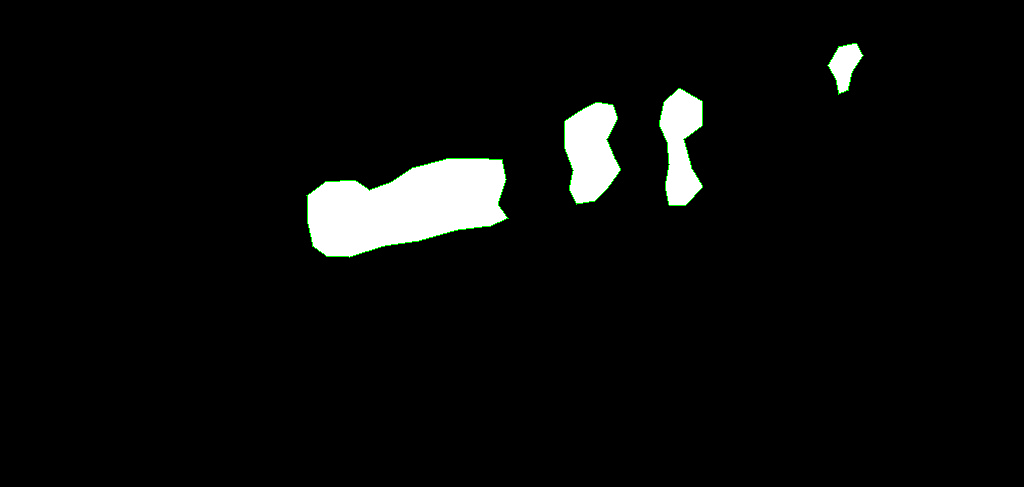

done


In [42]:
# 211108 contour detection 으로 mask들 찾아기
import os
import cv2
from shapely.geometry import Polygon
import numpy as np

from google.colab.patches import cv2_imshow # for colab
# import geopandas as gpd



sample_dir = '/content/accida_segmentation_dataset_v1/dent/valid/masks/20190525_6658_23880481_921eab5693426c2a89f542dfed72e8ca.jpg'

# os.chdir('C:/Users/user/Desktop/hehe/') #폴더 경로
img = cv2.imread(sample_dir) #파일명

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) #흑백사진으로 변환
ret, binary = cv2.threshold(gray, 240, 255, 0) 

contours, h = cv2.findContours(binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
image = cv2.drawContours(img, contours, -1, (0,255,0), 1)

cv2_imshow(image)

# cv2.drawContours 로 contour 구하고 각 mask 구함


print('done')

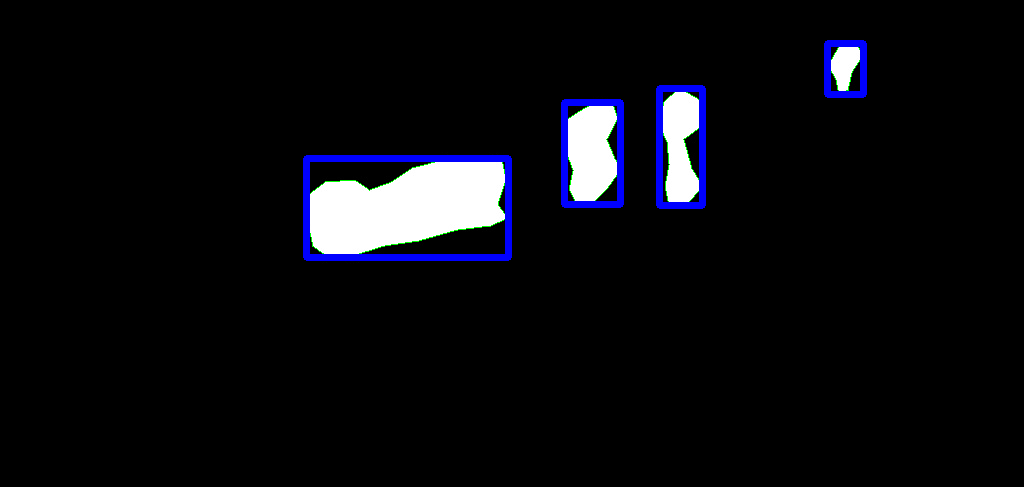

In [44]:
bbox = []

for idx, contour in enumerate(contours):
  c = np.array(contour)
  x_min = c[:,:,0].min()
  x_max = c[:,:,0].max()
  y_min = c[:,:,1].min()
  y_max = c[:,:,1].max()

  bbox.append([x_min, y_min, x_max, y_max])

  cv2.rectangle(img,(x_min,y_min),(x_max,y_max),(255,0,0),5)
  
cv2_imshow(img)


In [46]:
for bboxs in bbox:
  print(bboxs)

[306, 158, 508, 257]
[564, 102, 620, 204]
[659, 88, 702, 205]
[827, 43, 863, 94]


In [60]:
mask_path = os.path.join("/content/accida_segmentation_dataset_v1/dent/train", "masks", "20190223_11917_20255505_7f990d082050b9753fc4810c7bf6e1e4.jpg")

# mask_path = os.path.join("/content/accida_segmentation_dataset_v1/dent/train", "masks", "20190223_11917_20255505_7f990d082050b9753fc4810c7bf6e1e4.jpg")
# testmask = Image.open(mask_path).convert('L')
# testmask = np.array(testmask)
# print(testmask.shape)
# plt.imshow(testmask, 'gray')
# plt.show()

def get_name(testmask, mask_path):
  # file name 확인 
  # print("="*40)
  # print("file name, basic info check")
  filename = mask_path.split("/")[-1]
  # print(f'file_name : {filename}')
  if 'augment' in filename:
    # print(f'filename has augment in its name')
    file_seg = filename.split("_")
    file_ = ''.join([file_seg[0],'_',file_seg[1],'_',file_seg[-1]])
    # print(f'id augment O : {file_}')
  else:
    file_ = filename.split("_")
    file_ = ''.join([file_[0],'_',file_[1]])
    # print(f'id : {file_}')
  
  # print(f'height : {testmask.shape[1]}')
  # print(f'width : {testmask.shape[0]}')
  names = [filename,testmask.shape[0],testmask.shape[1]]
  return names # filename, width, height

# def get_bbox(testmask, mask_path):
#   # 이미지 마스크 확인 
#   # print("="*40)
#   # print("image mask check")
#   # print(np.unique(testmask))  #[0,1,2,3,4,5,6,7,248,249,250,251,252,253,254,255] => 0,255만 남아야하는데 데이터가 이상함
#   testmask = np.where(testmask < 10, 0, testmask) # 10이하의 값들은 0으로 바꿔줌
#   testmask = np.where(testmask > 245, 255, testmask) # 245이상의 값들은 255으로 바꿔줌


#   # print(f'total pixel : {testmask.shape[0]*testmask.shape[1]}')
#   # print(len(np.where(testmask==255)[0]))
#   # print(len(np.where(testmask==255)[1]))

#   # bounding box coordinates
#   x_list = np.where(testmask==255)[0]
#   y_list = np.where(testmask==255)[1]

#   # np.where()[0] -> x 좌표, [1] -> y 좌표
#   # _x_list = np.where(testmask==0)[0]
#   # _y_list = np.where(testmask==0)[1]
#   # print(_x_list.max())
#   if len(x_list):
#     x_min = x_list.min()
#     x_max = x_list.max()
#     y_min = y_list.min()
#     y_max = y_list.max()
#     # print(f'x min : {x_list.min()}, x max : {x_list.max()}')
#     # print(f'y min : {y_list.min()}, x max : {y_list.max()}')

#  # label part
#     # print(f"category id : dent:0, scratch:1, spacing:2 ")
#     if 'dent' in mask_path:
#       dmg = 0
#     elif 'scratch' in mask_path:
#       dmg = 1
#     elif 'spacing' in mask_path:
#       dmg = 2
#     else:
#       dmg = 99


#     height = y_list.max()-y_list.min()
#     width = x_list.max()-x_list.min()
#     # print(f'bbox [{x_min},{y_min},{width},{height}]')
# # fit bounding box format for dataset
#   # - https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/
#   # - https://stackoverflow.com/questions/51420188/the-training-labels-in-kitti-dataset/53733559
#     # bbox = [x_min, y_min, width, height] # coco
#     bbox = [x_min, y_min, x_max, y_max] # kitti
#     return bbox, dmg

#   else:
#     # print('no masks')
#     return [0,0,0,0], 98


print('function define done')

function define done


In [85]:
def get_bbox(testmask, mask_path):
  # 이미지 마스크 확인 
  # print("="*40)
  # print("image mask check")
  # print(np.unique(testmask))  #[0,1,2,3,4,5,6,7,248,249,250,251,252,253,254,255] => 0,255만 남아야하는데 데이터가 이상함
  testmask = np.where(testmask < 10, 0, testmask) # 10이하의 값들은 0으로 바꿔줌
  testmask = np.where(testmask > 245, 255, testmask) # 245이상의 값들은 255으로 바꿔줌

  bbox = []


  # print(f'total pixel : {testmask.shape[0]*testmask.shape[1]}')
  # print(len(np.where(testmask==255)[0]))
  # print(len(np.where(testmask==255)[1]))

 # bounding box coordinates
  x_list = np.where(testmask==255)[0]
  y_list = np.where(testmask==255)[1]

 # np.where()[0] -> x 좌표, [1] -> y 좌표
  # _x_list = np.where(testmask==0)[0]
  # _y_list = np.where(testmask==0)[1]
  if len(x_list):
    x_min = x_list.min()
    x_max = x_list.max()
    y_min = y_list.min()
    y_max = y_list.max()
    # print(f'x min : {x_list.min()}, x max : {x_list.max()}')
    # print(f'y min : {y_list.min()}, x max : {y_list.max()}')

 # label part
    # print(f"category id : dent:0, scratch:1, spacing:2 ")
    if 'dent' in mask_path:
      dmg = 0
    elif 'scratch' in mask_path:
      dmg = 1
    elif 'spacing' in mask_path:
      dmg = 2
    else:
      dmg = 99

    height = y_list.max()-y_list.min()
    width = x_list.max()-x_list.min()
    # print(f'bbox [{x_min},{y_min},{width},{height}]')
# fit bounding box format for dataset
  # - https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/
  # - https://stackoverflow.com/questions/51420188/the-training-labels-in-kitti-dataset/53733559
    # bbox = [x_min, y_min, width, height] # coco

# mask to bbox
    ret, binary = cv2.threshold(testmask, 240, 255, 0) 

    contours, h = cv2.findContours(binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    image = cv2.drawContours(img, contours, -1, (0,255,0), 1)

    for idx, contour in enumerate(contours):
      c = np.array(contour)
      x_min = c[:,:,0].min()
      x_max = c[:,:,0].max()
      y_min = c[:,:,1].min()
      y_max = c[:,:,1].max()
      bbox.append([x_min, y_min, x_max, y_max])
    # print(mask_path)

    #   cv2.rectangle(img,(x_min,y_min),(x_max,y_max),(255,0,0),5)
    # cv2_imshow(img)

    # bbox = [x_min, y_min, x_max, y_max] # kitti
    return bbox, dmg

  else:
    # print('no masks')
    return [[0,0,0,0]], 98

In [83]:
# directory : content여야함
# %cd ..
# %cd content
!ls

accida_segmentation_dataset_v1		    gdrive	 sample_data
dataset_accida_segmentation_dataset_v1.zip  mmdetection


In [86]:
# !ls
# file_path = 'accida_segmentation_dataset_v1/dent/test/masks/'

_label = {0:'dent', 1:'scratch', 2:'spacing', 99:'none',98:'none'}

file_root = 'accida_segmentation_dataset_v1/' # 설정 중요
class_dir = ['dent', 'scratch', 'spacing']
data_type = ['train', 'test', 'valid']


for cls_dir in class_dir:
  for data_dir in data_type:
    file_path = os.path.join(file_root,cls_dir, data_dir,'masks')
    print(file_path)

    file_list = os.listdir(file_path)
    print('file list length :',len(file_list))

  
    for idx,mask_dir in enumerate(file_list):
    
      mask_path =  os.path.join(file_path,mask_dir) 
      testmask = Image.open(mask_path).convert('L')
      testmask = np.array(testmask)


    # extract info
      data2save = ''
      names = get_name(testmask, mask_path)
      bboxs, lbl = get_bbox(testmask, mask_path)
      # print(bboxs)
      for idx, bbox in enumerate(bboxs):
        # print('in ',idx, bbox)
        (x_min, y_min, x_max, y_max) = bbox
        # print('bbox from get_bbox : ', bbox, ' label : ', lbl, ' name : ', names)
        data2save += f'{_label[lbl]} {x_min} {y_min} {x_max} {y_max}'
        if idx < len(bboxs)-1:
          data2save = data2save+'\n'

      # print(data2save)


    # save file to certain directory
      save_path = os.path.abspath(os.path.join(file_path, '..')) # 부모 폴더시 '../..' 대신 os.pardir()

      save_path_chk = os.path.join(save_path, 'labels2')
      try:
        os.stat(save_path_chk)
      except:
        os.mkdir(save_path_chk)
      save_file = os.path.join(save_path, 'labels2',mask_dir.split(".")[-2])
      
      file = open(save_file+'.txt', 'w')
      file.write(data2save)
      file.close()
    print(f'{file_path} done')

    

accida_segmentation_dataset_v1/dent/train/masks
file list length : 2132
accida_segmentation_dataset_v1/dent/train/masks done
accida_segmentation_dataset_v1/dent/test/masks
file list length : 267
accida_segmentation_dataset_v1/dent/test/masks done
accida_segmentation_dataset_v1/dent/valid/masks
file list length : 267
accida_segmentation_dataset_v1/dent/valid/masks done
accida_segmentation_dataset_v1/scratch/train/masks
file list length : 2132
accida_segmentation_dataset_v1/scratch/train/masks done
accida_segmentation_dataset_v1/scratch/test/masks
file list length : 267
accida_segmentation_dataset_v1/scratch/test/masks done
accida_segmentation_dataset_v1/scratch/valid/masks
file list length : 267
accida_segmentation_dataset_v1/scratch/valid/masks done
accida_segmentation_dataset_v1/spacing/train/masks
file list length : 1232
accida_segmentation_dataset_v1/spacing/train/masks done
accida_segmentation_dataset_v1/spacing/test/masks
file list length : 155
accida_segmentation_dataset_v1/spaci

In [18]:
# file directory check is needed
file_path = 'accida_segmentation_dataset_v1/dent/test/masks/'

_label = {0:'dent', 1:'scratch', 2:'spacing', 99:'none',98:'none'}

file_root = 'accida_segmentation_dataset_v1/' # 설정 중요
class_dir = ['dent', 'scratch', 'spacing']
data_type = ['valid','train', 'test']


for cls_dir in class_dir:
  for data_dir in data_type:
    # ann = []
    ann = ''
    file_path = os.path.join(file_root,cls_dir, data_dir,'masks')
    print(file_path)

    file_list = os.listdir(file_path)
    print('file list length :',len(file_list))

# ===================================================================
    te = 0
    for idx,mask_dir in enumerate(file_list):

    
      mask_path =  os.path.join(file_path,mask_dir) 
      testmask = Image.open(mask_path).convert('L')
      testmask = np.array(testmask)


    # extract info
      names = get_name(testmask, mask_path)
      bbox, lbl = get_bbox(testmask, mask_path)
      (x_min, y_min, x_max, y_max) = bbox
      # print('bbox from get_bbox : ', bbox, ' label : ', lbl, ' name : ', names)
      data2save = f'{_label[lbl]} {x_min} {y_min} {x_max} {y_max}'
      # print(data2save)


    # save file to certain directory
      save_path = os.path.abspath(os.path.join(file_path, '..')) # 부모 폴더시 '../..' 대신 os.pardir()

      save_path_chk = os.path.join(save_path, 'labels')
      try:
        os.stat(save_path_chk)
      except:
        os.mkdir(save_path_chk)
      save_file = os.path.join(save_path, 'labels',mask_dir.split(".")[-2])
      
      ann_ = mask_dir.split(".")[-2] + '\n'
      # print(ann_)
      ann = ann + ann_
      
    # Label text file
      file = open(save_file, 'w')
      file.write(data2save)
      file.close()


  # annotation text file
    ann_name = os.path.join(save_path,'annotation_socar.txt')
    file_ann = open(ann_name,'w')
    file_ann.write(str(ann))
    file_ann.close()


    print(f'{file_path} done')


    # break

    

accida_segmentation_dataset_v1/dent/valid/masks
file list length : 267
accida_segmentation_dataset_v1/dent/valid/masks done
accida_segmentation_dataset_v1/dent/train/masks
file list length : 2132
accida_segmentation_dataset_v1/dent/train/masks done
accida_segmentation_dataset_v1/dent/test/masks
file list length : 267
accida_segmentation_dataset_v1/dent/test/masks done
accida_segmentation_dataset_v1/scratch/valid/masks
file list length : 267
accida_segmentation_dataset_v1/scratch/valid/masks done
accida_segmentation_dataset_v1/scratch/train/masks
file list length : 2132
accida_segmentation_dataset_v1/scratch/train/masks done
accida_segmentation_dataset_v1/scratch/test/masks
file list length : 267
accida_segmentation_dataset_v1/scratch/test/masks done
accida_segmentation_dataset_v1/spacing/valid/masks
file list length : 154
accida_segmentation_dataset_v1/spacing/valid/masks done
accida_segmentation_dataset_v1/spacing/train/masks
file list length : 1232
accida_segmentation_dataset_v1/spac

In [ ]:
!ls

accida_segmentation_dataset_v1		    gdrive	 sample_data
dataset_accida_segmentation_dataset_v1.zip  mmdetection


### Dataset code
- mmdetection 밑에서 설치하고 이부ㄴ으로 와야함

In [19]:
# mmdetection 에서 해야는 코드
%cd mmdetection

/content/mmdetection


In [1]:


import copy
import os.path as osp

import mmcv
import numpy as np
import mmdet


from mmdet.datasets.builder import DATASETS
from mmdet.datasets.custom import CustomDataset

@DATASETS.register_module()
class socarDataset(CustomDataset):

    CLASSES = ('scratch','none')#,'none', 'dent', 'spacing')

    def load_annotations(self, ann_file):
        cat2label = {k: i for i, k in enumerate(self.CLASSES)}
        # load image list from file
        image_list = mmcv.list_from_file(self.ann_file)
    
        data_infos = []
        # convert annotations to middle format
        for image_id in image_list:
            filename = f'{self.img_prefix}/{image_id}.jpg'
            image = mmcv.imread(filename)
            height, width = image.shape[:2]
    
            data_info = dict(filename=f'{image_id}.jpg', width=width, height=height)
    
            # load annotations
            label_prefix = self.img_prefix.replace('images', 'labels')
            lines = mmcv.list_from_file(osp.join(label_prefix, f'{image_id}.txt'))
    
            content = [line.strip().split(' ') for line in lines]
            bbox_names = [x[0] for x in content]
            bboxes = [[float(info) for info in x[1:]] for x in content] # 이렇게 하면 되겠지??
    
            gt_bboxes = []
            gt_labels = []
            gt_bboxes_ignore = []
            gt_labels_ignore = []
    
            # filter 'DontCare'
            for bbox_name, bbox in zip(bbox_names, bboxes):
                if bbox_name in cat2label:
                    gt_labels.append(cat2label[bbox_name])
                    gt_bboxes.append(bbox)
                else:
                    gt_labels_ignore.append(-1)
                    gt_bboxes_ignore.append(bbox)

            data_anno = dict(
                bboxes=np.array(gt_bboxes, dtype=np.float32).reshape(-1, 4),
                labels=np.array(gt_labels, dtype=np.long),
                bboxes_ignore=np.array(gt_bboxes_ignore,
                                       dtype=np.float32).reshape(-1, 4),
                labels_ignore=np.array(gt_labels_ignore, dtype=np.long))

            data_info.update(ann=data_anno)
            data_infos.append(data_info)

        return data_infos



### Training code
- /content/mmdetection/configs/_base_/schedules/schedule_1x.py 에서 epoch 수정 가능

In [3]:
%cd mmdetection

/content/mmdetection


In [ ]:
Config

mmcv.utils.config.Config

In [4]:
# directory
from mmcv import Config
cfg = Config.fromfile('./configs/faster_rcnn/faster_rcnn_r50_caffe_fpn_mstrain_1x_coco.py')
# cfg = Config.fromfile('./configs/mask_rcnn/mask_rcnn_r50_caffe_fpn_poly_1x_coco_v1.py')
# cfg = Config.fromfile('./configs/mask_rcnn/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco.py')


In [5]:
from mmdet.apis import set_random_seed

# Modify dataset type and path
cfg.dataset_type = 'socarDataset'
cfg.data_root = '../accida_segmentation_dataset_v1/scratch/'

cfg.data.test.type = 'socarDataset'
cfg.data.test.data_root = '../accida_segmentation_dataset_v1/scratch/'
cfg.data.test.ann_file = 'test/annotation_socar.txt'
cfg.data.test.img_prefix = 'test/images'

cfg.data.train.type = 'socarDataset'
cfg.data.train.data_root = '../accida_segmentation_dataset_v1/scratch/'
cfg.data.train.ann_file = 'train/annotation_socar.txt'
cfg.data.train.img_prefix = 'train/images'

cfg.data.val.type = 'socarDataset'
cfg.data.val.data_root = '../accida_segmentation_dataset_v1/scratch/'
cfg.data.val.ann_file = 'valid/annotation_socar.txt'
cfg.data.val.img_prefix = 'valid/images'

# modify num classes of the model in box head
cfg.model.roi_head.bbox_head.num_classes = 2
# We can still use the pre-trained Mask RCNN model though we do not need to
# use the mask branch
# pretrained model  'https://download.openmmlab.com/mmdetection/v2.0/mask_rcnn/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth' 

cfg.load_from='checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth'
# cfg.load_from = 'checkpoints/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './tutorial_exps'

# The original learning rate (LR) is set for 8-GPU training.
# We divide it by 8 since we only use one GPU.
cfg.optimizer.lr = 0.0001 # 0.02 / 8
cfg.lr_config.warmup = None           # 이거 뭐더라...
cfg.log_config.interval = 10

# Change the evaluation metric since we use customized dataset.
cfg.evaluation.metric = 'mAP'
# We can set the evaluation interval to reduce the evaluation times
cfg.evaluation.interval = 5 # 결과가 안뜬게 얘때문인 -> epoch 몇 당 evaluation 결과를 보여주는지에 대한 부분
# We can set the checkpoint saving interval to reduce the storage cost
cfg.checkpoint_config.interval = 10


# Set seed thus the results are more reproducible
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)


# We can initialize the logger for training and have a look
# at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

Config:
model = dict(
    type='FasterRCNN',
    backbone=dict(
        type='ResNet',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=dict(type='BN', requires_grad=False),
        norm_eval=True,
        style='caffe',
        init_cfg=dict(
            type='Pretrained',
            checkpoint='open-mmlab://detectron2/resnet50_caffe')),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=5),
    rpn_head=dict(
        type='RPNHead',
        in_channels=256,
        feat_channels=256,
        anchor_generator=dict(
            type='AnchorGenerator',
            scales=[8],
            ratios=[0.5, 1.0, 2.0],
            strides=[4, 8, 16, 32, 64]),
        bbox_coder=dict(
            type='DeltaXYWHBBoxCoder',
            target_means=[0.0, 0.0, 0.0, 0.0],
            target_stds=[1.0, 1.0, 1.0, 1.0]),
        loss_cls=dict(
            type='Cro

In [6]:
!ls

checkpoints   docs	   mmdet.egg-info   requirements      tests
CITATION.cff  docs_zh-CN   model-index.yml  requirements.txt  tools
configs       LICENSE	   pytest.ini	    resources	      tutorial_exps
demo	      MANIFEST.in  README.md	    setup.cfg
docker	      mmdet	   README_zh-CN.md  setup.py


In [ ]:
%cd mmdetection/

[Errno 2] No such file or directory: 'mmdetection/'
/content/mmdetection


In [6]:

from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector


# Build dataset

datasets = [build_dataset(cfg.data.train)]

# Build the detector
model = build_detector(
    cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_detector(model, datasets, cfg, distributed=False, validate=True)

/content/mmdetection/mmdet/datasets/custom.py:157: UserWarning: CustomDataset does not support filtering empty gt images.
  'CustomDataset does not support filtering empty gt images.')
2021-11-08 08:04:57,778 - mmdet - INFO - load checkpoint from checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth
2021-11-08 08:04:57,780 - mmdet - INFO - Use load_from_local loader
2021-11-08 08:04:57,911 - mmdet - WARNING - The model and loaded state dict do not match exactly

size mismatch for roi_head.bbox_head.fc_cls.weight: copying a param with shape torch.Size([81, 1024]) from checkpoint, the shape in current model is torch.Size([3, 1024]).
size mismatch for roi_head.bbox_head.fc_cls.bias: copying a param with shape torch.Size([81]) from checkpoint, the shape in current model is torch.Size([3]).
size mismatch for roi_head.bbox_head.fc_reg.weight: copying a param with shape torch.Size([320, 1024]) from checkpoint, the shape in current model is torch.Size([8, 1024]).
size mismatch for roi_

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 267/267, 13.5 task/s, elapsed: 20s, ETA:     0s
---------------iou_thr: 0.5---------------


2021-11-08 08:29:58,040 - mmdet - INFO - 
+---------+------+-------+--------+-------+
| class   | gts  | dets  | recall | ap    |
+---------+------+-------+--------+-------+
| scratch | 1153 | 10729 | 0.185  | 0.008 |
| none    | 74   | 0     | 0.000  | 0.000 |
+---------+------+-------+--------+-------+
| mAP     |      |       |        | 0.004 |
+---------+------+-------+--------+-------+
2021-11-08 08:29:58,044 - mmdet - INFO - Epoch(val) [5][267]	AP50: 0.0040, mAP: 0.0041
2021-11-08 08:30:03,147 - mmdet - INFO - Epoch [6][10/1066]	lr: 1.000e-04, eta: 1:13:36, time: 0.496, data_time: 0.230, memory: 3608, loss_rpn_cls: 0.1352, loss_rpn_bbox: 0.0465, loss_cls: 0.1120, acc: 97.3242, loss_bbox: nan, loss: nan
2021-11-08 08:30:05,776 - mmdet - INFO - Epoch [6][20/1066]	lr: 1.000e-04, eta: 1:13:33, time: 0.263, data_time: 0.022, memory: 3608, loss_rpn_cls: 0.1123, loss_rpn_bbox: 0.0412, loss_cls: 0.0870, acc: 98.0371, loss_bbox: nan, loss: nan
2021-11-08 08:30:08,568 - mmdet - INFO - Epoc

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 267/267, 13.5 task/s, elapsed: 20s, ETA:     0s
---------------iou_thr: 0.5---------------


2021-11-08 08:54:36,606 - mmdet - INFO - 
+---------+------+-------+--------+-------+
| class   | gts  | dets  | recall | ap    |
+---------+------+-------+--------+-------+
| scratch | 1153 | 14041 | 0.319  | 0.033 |
| none    | 74   | 0     | 0.000  | 0.000 |
+---------+------+-------+--------+-------+
| mAP     |      |       |        | 0.016 |
+---------+------+-------+--------+-------+
2021-11-08 08:54:36,611 - mmdet - INFO - Epoch(val) [10][267]	AP50: 0.0160, mAP: 0.0164
2021-11-08 08:54:41,692 - mmdet - INFO - Epoch [11][10/1066]	lr: 1.000e-05, eta: 0:48:37, time: 0.494, data_time: 0.231, memory: 3608, loss_rpn_cls: 0.0898, loss_rpn_bbox: 0.0374, loss_cls: 0.1099, acc: 97.1777, loss_bbox: nan, loss: nan
2021-11-08 08:54:44,265 - mmdet - INFO - Epoch [11][20/1066]	lr: 1.000e-05, eta: 0:48:34, time: 0.258, data_time: 0.019, memory: 3608, loss_rpn_cls: 0.0823, loss_rpn_bbox: 0.0344, loss_cls: 0.0835, acc: 98.0176, loss_bbox: nan, loss: nan
2021-11-08 08:54:46,878 - mmdet - INFO - E

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 267/267, 13.3 task/s, elapsed: 20s, ETA:     0s
---------------iou_thr: 0.5---------------


2021-11-08 09:19:11,988 - mmdet - INFO - 
+---------+------+-------+--------+-------+
| class   | gts  | dets  | recall | ap    |
+---------+------+-------+--------+-------+
| scratch | 1153 | 13579 | 0.330  | 0.036 |
| none    | 74   | 0     | 0.000  | 0.000 |
+---------+------+-------+--------+-------+
| mAP     |      |       |        | 0.018 |
+---------+------+-------+--------+-------+
2021-11-08 09:19:11,992 - mmdet - INFO - Epoch(val) [15][267]	AP50: 0.0180, mAP: 0.0182
2021-11-08 09:19:17,009 - mmdet - INFO - Epoch [16][10/1066]	lr: 1.000e-06, eta: 0:24:12, time: 0.490, data_time: 0.232, memory: 3608, loss_rpn_cls: 0.0724, loss_rpn_bbox: 0.0340, loss_cls: 0.1143, acc: 97.0898, loss_bbox: nan, loss: nan
2021-11-08 09:19:19,518 - mmdet - INFO - Epoch [16][20/1066]	lr: 1.000e-06, eta: 0:24:10, time: 0.249, data_time: 0.018, memory: 3608, loss_rpn_cls: 0.0607, loss_rpn_bbox: 0.0228, loss_cls: 0.0886, acc: 97.7441, loss_bbox: nan, loss: nan
2021-11-08 09:19:21,975 - mmdet - INFO - E

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 267/267, 13.2 task/s, elapsed: 20s, ETA:     0s
---------------iou_thr: 0.5---------------


2021-11-08 09:43:50,525 - mmdet - INFO - 
+---------+------+-------+--------+-------+
| class   | gts  | dets  | recall | ap    |
+---------+------+-------+--------+-------+
| scratch | 1153 | 13848 | 0.329  | 0.038 |
| none    | 74   | 0     | 0.000  | 0.000 |
+---------+------+-------+--------+-------+
| mAP     |      |       |        | 0.019 |
+---------+------+-------+--------+-------+
2021-11-08 09:43:50,529 - mmdet - INFO - Epoch(val) [20][267]	AP50: 0.0190, mAP: 0.0190


### Test code

/content/mmdetection/mmdet/datasets/utils.py:69: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  'data pipeline in your config file.', UserWarning)


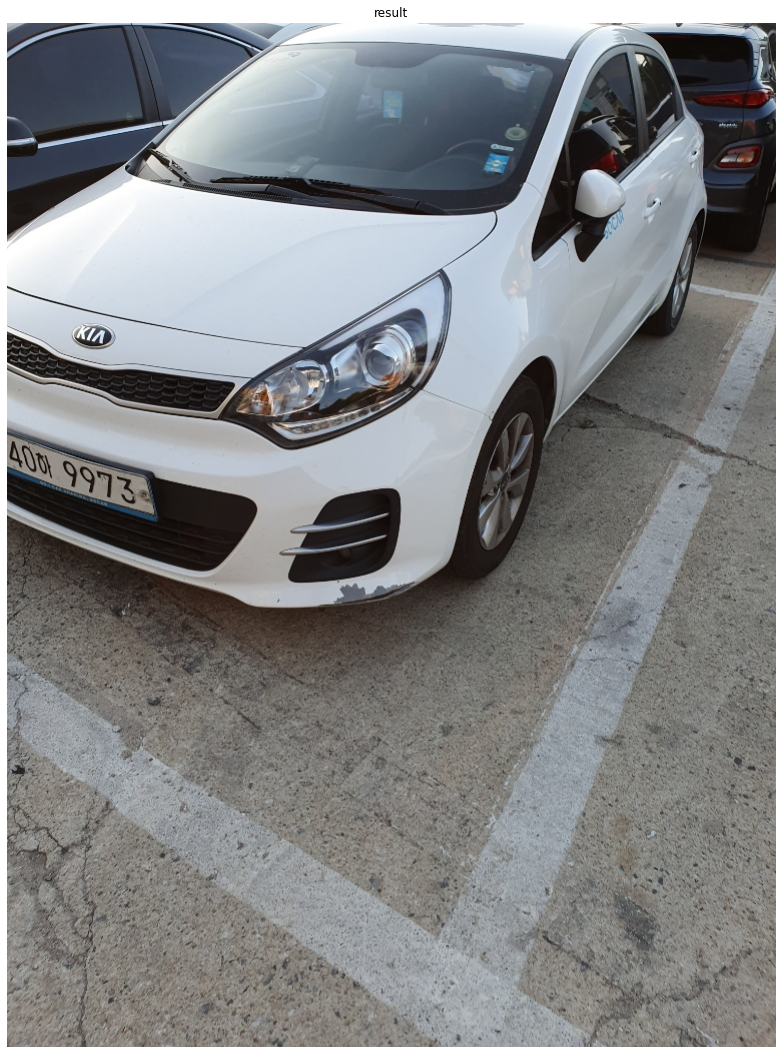

[array([[2.03611176e+02, 8.98784256e+01, 5.32500488e+02, 8.03088074e+02,
        1.83564782e-01],
       [5.30781593e+01, 8.16013947e+01, 4.76115204e+02, 6.46471985e+02,
        1.35541260e-01],
       [2.81285736e+02, 1.51058670e+02, 6.76090210e+02, 9.01691162e+02,
        1.17128313e-01],
       [2.11339935e+02, 1.08382042e+02, 7.03988525e+02, 5.59749390e+02,
        1.02115862e-01],
       [1.87068253e+02, 4.70292511e+02, 5.23729248e+02, 1.00367548e+03,
        9.77934375e-02],
       [1.81838242e+02, 5.85076599e+02, 3.65864410e+02, 1.01660791e+03,
        7.43377283e-02],
       [7.93182144e+01, 4.83194763e+02, 4.09041351e+02, 1.01029028e+03,
        6.65720105e-02],
       [3.04886505e+02, 4.99828735e+02, 6.76200806e+02, 1.00157086e+03,
        6.57658502e-02],
       [3.70450958e+02, 5.23216248e+02, 5.42626221e+02, 9.89936951e+02,
        5.45624681e-02],
       [4.12741516e+02, 4.64351578e+01, 7.58220276e+02, 6.48940063e+02,
        5.13727926e-02]], dtype=float32), array([], sh

In [ ]:
from mmdet.apis import inference_detector, init_detector, show_result_pyplot
img = mmcv.imread('/content/accida_segmentation_dataset_v1/scratch/test/images/20190528_7341_24083827_7955ca5547235d5463a9e09eab58be31.jpg')

model.cfg = cfg
result = inference_detector(model, img)
show_result_pyplot(model, img, result)
print(result)

In [7]:
import os
from mmdet.apis import inference_detector, init_detector, show_result_pyplot

test_file_path = '../accida_segmentation_dataset_v1/scratch/test/images/'
test_file_list = os.listdir(test_file_path)

# save_file_path = '../accida_segmentation_dataset_v1/output/'
save_file_path = '/content/gdrive/MyDrive/KIM123/실험결과/result/'

print(len(test_file_list))

model.cfg = cfg
for idx, testfile in enumerate(test_file_list):
  # if idx < 20:
  print(testfile)
  img = mmcv.imread(test_file_path + testfile)
  result = inference_detector(model, img)
  # show_result_pyplot(model, img, result) # show under the colab cell
  model.show_result(img, result, out_file=save_file_path + testfile) # save image with result




267
20180101_10778_10632865_f61d4ae8ecaa12e9e58411e24d7d0898_augmented1.jpg


/content/mmdetection/mmdet/datasets/utils.py:69: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  'data pipeline in your config file.', UserWarning)


20190412_12296_21795099_c7cf7aeea33ff353cf259cb26c04189a.jpg
20190415_12512_21950700_e83f36dfc10e9ce83b869ec20a8aa111.jpg
20190517_8111_23459904_bbcfd61f3e2494d661591ae2c19c3671.jpg
20180101_10778_10632859_e8acd63c836bd1785200c20811197ef7.jpg
20181212_14203_18323720_fc67650e0ea20c1f0e37100e0ac6e8ee_augmented11.jpg
20190525_4396_23917088_211b2f8930783d66ca64d4301cc31310.jpg
20190412_6591_21819235_ab721a9fbbe8030b372b6ea13cc27bbc.jpg
20190410_4993_21739515_4d7a9103a53462aa89d1c6a29f7e10ea.jpg
20190513_13331_23254114_89d2356bfc47a283484c708cde1ba2cf.jpg
20190504_14537_22716236_a1a383835d9e16f4218c3ebd5ef671a6.jpg
20190225_4357_20336242_83749c3164beaaa4b82c57d0d9bfac5f.jpg
20180206_4966_11200164_39862d4c62ece769c0dbeebfa25f9921_augmented1.jpg
20190410_8578_21732834_c83901c9605522dc753c9026d8fc88b6.jpg
20190526_7272_23992253_e94e94612e3c4726c17b43467cd9a9ff.jpg
20190420_8386_22132564_a5b8cc8d03c84958a16c6739e26ec9f9.jpg
20190525_8135_23877859_2bc72289a67d7d290882ac3f41a7a335.jpg
20190525_72

## COCO Format
- [bbox format](https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/)
  - [x_min, y_min, width, height]
- annotations
  - segmentation : mask에 대한 정확한 정보 있을때
    - 우리도 있긴한데, [x 좌표],[y 좌표] or [x1,y1,x2,y2,... xn,yn] 어떤형탠지 알수 없음      
    
~~~python
'images': [
    {
        'file_name': 'COCO_val2014_000000001268.jpg',
        'height': 427,
        'width': 640,
        'id': 1268
    },
    ...
],
'annotations': [
    {
        'segmentation': [[192.81,
            247.09,
            ...
            219.03,
            249.06]],  # if you have mask labels
        'area': 1035.749,
        'iscrowd': 0,
        'image_id': 1268,
        'bbox': [192.81, 224.8, 74.73, 33.43],
        'category_id': 16,
        'id': 42986
    },
    ...
],
'categories': [
    {'id': 0, 'name': 'car'},
    ...
]
~~~

## Middle Format
~~~python
[
    {
        'filename': 'a.jpg',
        'width': 1280,
        'height': 720,
        'ann': {
            'bboxes': <np.ndarray, float32> (n, 4),
            'labels': <np.ndarray, int64> (n, ),
            'bboxes_ignore': <np.ndarray, float32> (k, 4), (optional field)
            'labels_ignore': <np.ndarray, int64> (k, )     (optional field)
        }
    },
    ...
]
~~~

# ETC

In [ ]:
# Let's take a look at the dataset image
import mmcv
import matplotlib.pyplot as plt

# img = mmcv.imread('kitti_tiny/training/image_2/000073.jpeg')
# plt.figure(figsize=(15, 10))
# plt.imshow(mmcv.bgr2rgb(img))
# plt.show()